In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv("../data/train.csv")
test=pd.read_csv("../data/test.csv")

In [3]:
data.head(10)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
5,5,15771669,Genovese,588,Germany,Male,36.0,4,131778.58,1,1.0,0.0,136024.31,1
6,6,15692819,Ch'ang,593,France,Female,30.0,8,144772.69,1,1.0,0.0,29792.11,0
7,7,15669611,Chukwuebuka,678,Spain,Male,37.0,1,138476.41,1,1.0,0.0,106851.60,0
8,8,15691707,Manna,676,France,Male,43.0,4,0.00,2,1.0,0.0,142917.13,0
9,9,15591721,Cattaneo,583,Germany,Male,40.0,4,81274.33,1,1.0,1.0,170843.07,0


In [4]:
test_final=test["id"]

In [5]:
def clean(data):
    data=data.drop(["id","CustomerId","Surname"],axis=1)
    
    floatcols=["Age","HasCrCard","IsActiveMember","Balance","EstimatedSalary"]
    data[floatcols]=data[floatcols].astype('int64')

    return data

In [6]:
data=clean(data)
test=clean(test)

In [7]:
data.head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33,3,0,2,1,0,181449,0
1,627,France,Male,33,1,0,2,1,1,49503,0
2,678,France,Male,40,10,0,2,1,0,184866,0
3,581,France,Male,34,2,148882,1,1,1,84560,0
4,716,Spain,Male,33,5,0,2,1,1,15068,0
5,588,Germany,Male,36,4,131778,1,1,0,136024,1
6,593,France,Female,30,8,144772,1,1,0,29792,0
7,678,Spain,Male,37,1,138476,1,1,0,106851,0
8,676,France,Male,43,4,0,2,1,0,142917,0
9,583,Germany,Male,40,4,81274,1,1,1,170843,0


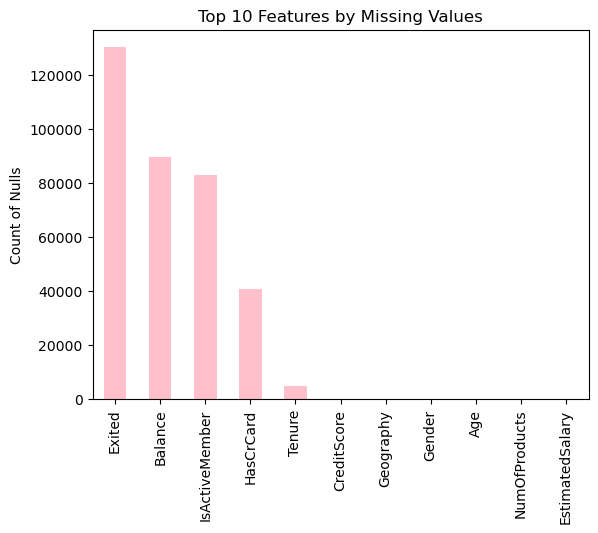

In [8]:
nulls=(data==0).sum().sort_values(ascending=False)
nulls.plot(kind='bar',color='pink')
plt.title('Top 10 Features by Missing Values')
plt.ylabel('Count of Nulls')
plt.show()

In [9]:
X=data.drop("Exited",axis=1)
y=data["Exited"]

In [10]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

catcols=["Geography","Gender"]
numcols=["Balance","IsActiveMember","HasCrCard","Tenure","CreditScore","Age","NumOfProducts","EstimatedSalary"]

In [12]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

def make_lgb_pipeline(numcols):
    preprocess=ColumnTransformer(
    transformers=[
        ("cat",OneHotEncoder(drop="first",handle_unknown="ignore"), catcols),
        ("num","passthrough",numcols),])
    lgb=Pipeline(steps=[
        ("preprocess",preprocess),
        ("model",LGBMClassifier(verbose=-1))])

    return lgb

In [13]:
lgb=make_lgb_pipeline(numcols)

lgb.fit(X_train,y_train)
lgb_predict=lgb.predict_proba(X_test)[:,1]
lgb_auc=roc_auc_score(y_test,lgb_predict)
print("ROC AUC:",lgb_auc)

ROC AUC: 0.8910349267731197


/Users/maudq/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [14]:
from sklearn.model_selection import cross_val_score

lgbscores=cross_val_score(
    lgb,
    X,
    y,
    cv=5,
    scoring="roc_auc")

print("Fold AUCs:", lgbscores)
print("Mean AUC:",lgbscores.mean())
print("Std AUC:", lgbscores.std())

/Users/maudq/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/maudq/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/maudq/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/maudq/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold AUCs: [0.89234636 0.88734237 0.88986191 0.88909859 0.88869085]
Mean AUC: 0.8894680151631291
Std AUC: 0.001655222687655472


/Users/maudq/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


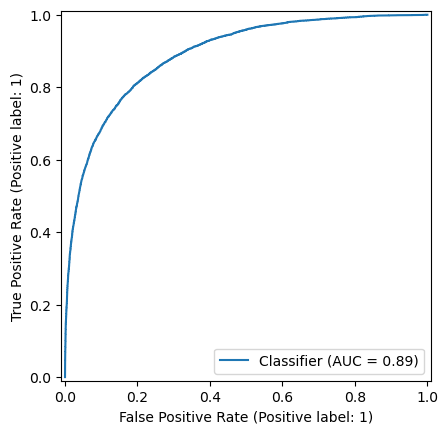

In [15]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test,lgb_predict)
plt.show()

In [16]:
lgb.get_params()

{'memory': None,
 'steps': [('preprocess',
   ColumnTransformer(transformers=[('cat',
                                    OneHotEncoder(drop='first',
                                                  handle_unknown='ignore'),
                                    ['Geography', 'Gender']),
                                   ('num', 'passthrough',
                                    ['Balance', 'IsActiveMember', 'HasCrCard',
                                     'Tenure', 'CreditScore', 'Age',
                                     'NumOfProducts', 'EstimatedSalary'])])),
  ('model', LGBMClassifier(verbose=-1))],
 'transform_input': None,
 'verbose': False,
 'preprocess': ColumnTransformer(transformers=[('cat',
                                  OneHotEncoder(drop='first',
                                                handle_unknown='ignore'),
                                  ['Geography', 'Gender']),
                                 ('num', 'passthrough',
                                  

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

lgbparam_dist={
    "model__num_leaves":randint(20,200),
    "model__max_depth":randint(3,10),
    "model__learning_rate":uniform(0.01,0.09),
    "model__min_child_samples":randint(10,100),
    "model__subsample":uniform(0.6,0.4),
    "model__colsample_bytree":uniform(0.6,0.4)}

lgb_search=RandomizedSearchCV(
    estimator=lgb,
    param_distributions=lgbparam_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    random_state=42)

lgb_search.fit(X,y)
print(lgb_search.best_score_,lgb_search.best_params_)

/Users/maudq/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/maudq/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/maudq/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/maudq/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/maudq/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with f

0.8896612510867081 {'model__colsample_bytree': np.float64(0.749816047538945), 'model__learning_rate': np.float64(0.09556428757689245), 'model__max_depth': 5, 'model__min_child_samples': 81, 'model__num_leaves': 40, 'model__subsample': np.float64(0.6624074561769746)}


In [18]:
lgb_final=make_lgb_pipeline(numcols)
lgb_final.set_params(
    model__colsample_bytree=np.float64(0.749816047538945),
    model__learning_rate=np.float64(0.09556428757689245),
    model__max_depth=5,
    model__min_child_samples=81,
    model__num_leaves=40,
    model__subsample=np.float64(0.6624074561769746))

lgb_final.fit(X_train,y_train)
lgb_final_predict=lgb_final.predict_proba(X_test)[:,1]
lgb_final_auc=roc_auc_score(y_test,lgb_final_predict)
print("ROC AUC:",lgb_final_auc)

ROC AUC: 0.8911006224017154


/Users/maudq/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [19]:
from catboost import CatBoostClassifier

cbm=CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    depth=6,
    learning_rate=0.05,
    iterations=1000,
    verbose=False)

cbm.fit(X_train,y_train,cat_features=catcols,eval_set=(X_test,y_test))
cbm_predict=cbm.predict_proba(X_test)[:,1]
cbm_auc=roc_auc_score(y_test,cbm_predict)
print("ROC AUC:",cbm_auc)

ROC AUC: 0.891465537100328


In [ ]:
cbm_scores=cross_val_score(cbm,X,y,cv=5,scoring="roc_auc",fit_params={"cat_features":catcols})

print("ROC:",cbm_scores.mean(),cbm_scores.std())

In [21]:
cbmparam_dist={
    "depth":[3,4,5,6,7,8],
    "learning_rate":[0.01,0.02,0.03,0.05,0.07,0.1],
    "l2_leaf_reg":[1,3,5,7,10,15,20],
    "bagging_temperature":[0.0,0.5,1.0,2.0,4.0],
    "border_count":[64,128,254]}

cbm_search=RandomizedSearchCV(
    estimator=cbm,
    param_distributions=cbmparam_dist,
    n_iter=10,
    scoring="roc_auc",
    cv=5,
    n_jobs=1,
    random_state=42)

cbm_search.fit(X,y,cat_features=catcols)
print(cbm_search.best_score_,cbm_search.best_params_)

0.8898942643537469 {'learning_rate': 0.05, 'l2_leaf_reg': 10, 'depth': 6, 'border_count': 254, 'bagging_temperature': 1.0}


In [23]:
from sklearn.ensemble import VotingClassifier

ensemble=VotingClassifier(
    estimators=[
        ("lgb",lgb_final),
        ("cat",cbm)],
    voting="soft",
    weights=[0.5,0.5])

ensemble.fit(X_train,y_train,cat_features=catcols)
ensemble_prediction=ensemble.predict_proba(X_test)[:,1]
ensemble_auc=roc_auc_score(y_test,ensemble_prediction)
print("Ensemble AUC:",ensemble_auc)

ValueError: Passing extra keyword arguments to VotingClassifier.fit is only supported if enable_metadata_routing=True, which you can set using `sklearn.set_config`. See the User Guide <https://scikit-learn.org/stable/metadata_routing.html> for more details. Extra parameters passed are: {'cat_features'}

In [26]:
p_lgb=lgb_final.predict_proba(X_test)[:,1]
p_cat=cbm.predict_proba(X_test)[:,1]

p_ensemble=0.5*p_lgb+0.5*p_cat
p_ensembleauc=roc_auc_score(y_test,p_ensemble)
print("Ensemble AUC:",p_ensembleauc)

Ensemble AUC: 0.8915431234528122


/Users/maudq/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [27]:
weights=np.linspace(0,1,21)
best_auc=-1
best_w=None

for w in weights:
    p_ensemble=w*p_lgb+(1-w)*p_cat
    auc=roc_auc_score(y_test,p_ensemble)
    if auc>best_auc:
        best_auc=auc
        best_w=w

print("Best w:", best_w)
print("Best val AUC:", best_auc)

Best w: 0.35000000000000003
Best val AUC: 0.8915751944653524


In [29]:
p_bestensemble=best_w*p_lgb+(1-best_w)*p_cat
best_ensembleauc=roc_auc_score(y_test,p_bestensemble)
print("Best ensemble AUC:", best_ensembleauc)

Best ensemble AUC: 0.8915751944653524


In [31]:
pp_lgb=lgb_final.predict_proba(test)[:,1]
pp_cat=cbm.predict_proba(test)[:,1]

/Users/maudq/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [32]:
final_ensemble=best_w*pp_lgb+(1-best_w)*pp_cat

In [35]:
submission=pd.DataFrame({
    "id":test_final.values,
    "target":final_ensemble})

In [36]:
submission.to_csv("submissionbc.csv",index=False)